In [51]:
import pandas as pd
import numpy as np
import config
import datetime
from sqlalchemy import text
import plotly
import plotly.express as px
import ipywidgets
from urllib.request import urlopen
import json
import plotly.graph_objects as go
import geopandas as gpd
import warnings
import pyproj
print(config.version)
print(config.connection_string)
print(plotly.__version__, ipywidgets.__version__, pd.__version__, np.__version__)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore', category=UserWarning) 

3.2.0.Dev
postgresql://postgres:sa@localhost/icip
6.3.1 8.1.7 2.0.0 1.26.4 3.6.1


[7.182147744020976, 43.64540566299893, 7.323476112735957, 43.7609095158693]
Layout({
    'autosize': False,
    'geo': {'center': {'lat': 43.70700217292261, 'lon': 7.258878431214523},
            'lataxis': {'range': [43.61032469792476, 43.79728535275482]},
            'lonaxis': {'range': [6.944078978288985, 7.553536695941796]},
            'projection': {'type': 'mercator'},
            'scope': 'europe',
            'showcountries': False,
            'showlakes': False,
            'showland': False,
            'showocean': False,
            'showrivers': False},
    'height': 650,
    'margin': {'b': 0, 'l': 0, 'pad': 4, 'r': 0, 't': 40},
    'paper_bgcolor': 'LightSteelBlue',
    'template': '...',
    'title': {'text': 'IRIS - Ville de Nice'},
    'width': 1500
})


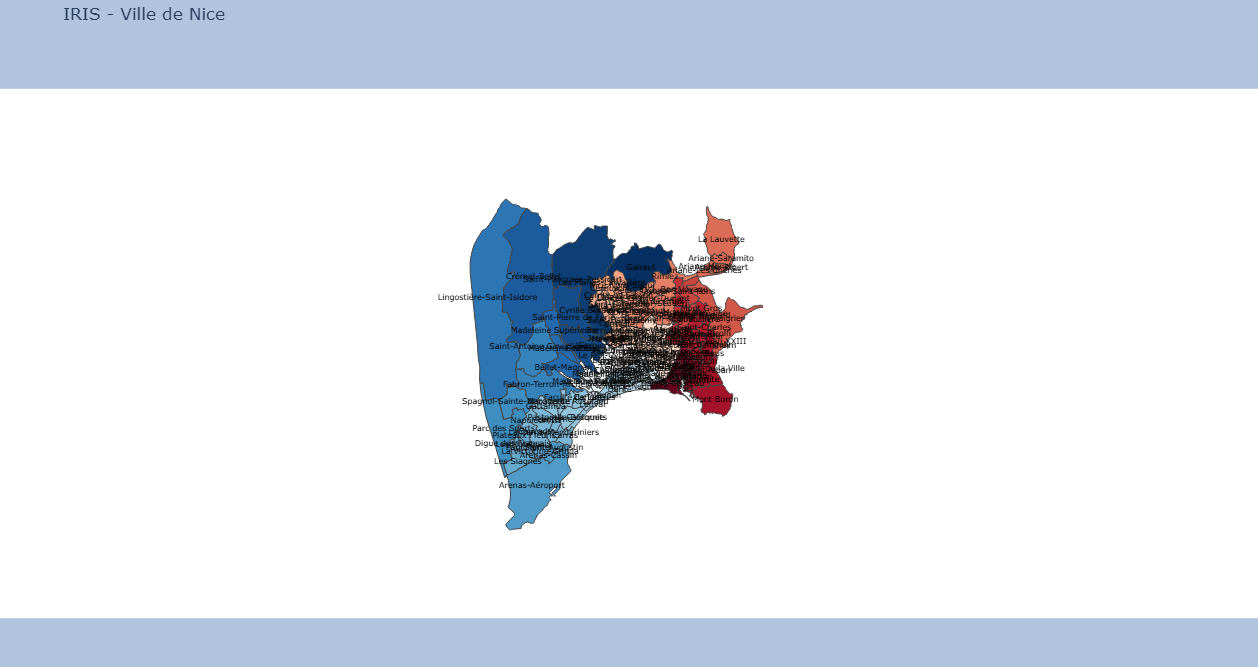

In [61]:
import geopandas as gpd
import plotly.graph_objects as go



# Charger et filtrer les données
gdf = gpd.read_file("contours-iris.gpkg")
# print(gdf["nom_commune"].unique())
gdf_nice = gdf[gdf["nom_commune"] == "Nice"].to_crs(epsg=4326)

# print(gdf_nice)
# Ajouter les étiquettes
gdf_nice_l93 = gdf_nice.to_crs(2154)
pts_l93 = gdf_nice_l93.geometry.representative_point()
pts = pts_l93.to_crs(4326)

gdf_nice["fid"] = gdf_nice.index

# Extraire les coordonnées des polygones
gdf_nice["lon"] = gdf_nice.geometry.centroid.x
gdf_nice["lat"] = gdf_nice.geometry.centroid.y

# Créer la figure
fig = go.Figure()


# Ajouter la couche choropleth
fig.add_trace(go.Choropleth(
    z=gdf_nice["code_iris"],
    locations=gdf_nice["fid"],
    locationmode="geojson-id",  # pas utilisé ici mais requis par l'API
    geojson=gdf_nice.__geo_interface__,
    text=gdf_nice.apply(
        lambda row: f"code_iris: {row['code_iris']}<br>type_iris: {row['type_iris']}<br>cleabs: {row['cleabs']}",
        axis=1
    ),
    hoverinfo="text",
    colorscale="RdBu",
    showscale=False,
))



fig.add_trace(go.Scattergeo(
    lon=pts.x,
    lat=pts.y,
    text=gdf_nice["nom_iris"],
    mode="text",
    textfont=dict(color="black", size=8),
    hoverinfo="skip",
    showlegend=False,
    textposition="middle center"
))

# Centrer la carte
center_lat = gdf_nice.geometry.centroid.y.mean()
center_lon = gdf_nice.geometry.centroid.x.mean()
max_lat = gdf_nice.geometry.centroid.y.max()
min_lat = gdf_nice.geometry.centroid.y.min()
max_lon = gdf_nice.geometry.centroid.x.max()
min_lon = gdf_nice.geometry.centroid.x.min()

gj_bbox = compute_bbox(gdf_nice.__geo_interface__)

# Mettre à jour la mise en page
fig.update_layout(
    geo=dict(
        scope="europe",
        projection_type="mercator",
        showland=False,
        showcountries=False,
        showocean=False,
        showlakes=False,
        showrivers=False,
        center={"lat": center_lat, "lon": center_lon},
        # fitbounds="locations",
        # projection_scale=1000,
        # center_lon=(gj_bbox[0]+gj_bbox[2])/2.0,
        # center_lat=(gj_bbox[1]+gj_bbox[3])/2.0,
        # lonaxis_range=[gj_bbox[0]-0.2, gj_bbox[2]+0.2],
        # lataxis_range=[gj_bbox[1]-0.04, gj_bbox[3]+0.02],
        lonaxis_range=[min_lon-0.25, max_lon+0.25],
        lataxis_range=[min_lat-0.05, max_lat+0.05],
    ),
    title="IRIS - Ville de Nice",
    autosize=False,
    height=650,
    width=1500,
    paper_bgcolor="LightSteelBlue",
    margin=dict(
                        l=0,
                        r=0,
                        b=0,
                        t=40,
                        pad=4
                    ),

)
print(gj_bbox)
print(fig.layout)


fig.show() #onfig={"responsive": True})

# J'avais fais la même chose pour iscri

import plotly.io as pio
pio.write_html(fig, file="ma_carte.html", auto_open=True, include_plotlyjs="cdn", full_html=True, config={"responsive": True})

